# Set up tools, read in data

In [404]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
filename = "SandHill_VS_IDKeywordDescription.csv"

df = pd.read_csv(filename)
df = df[["EntityID", "Keywords", "FullDesc"]]
df[:5]

,EntityID,Keywords,FullDesc
0,53131,NaN,Developer of an application suite that helps b...
1,53135,NaN,Operator of the largest cable television netwo...
2,53138,"3D, model*",Provider of 3D modeling software for a broad r...
3,53139,NaN,"Provider of broadband access for businesses, I..."
4,53140,NaN,Developer of enhanced server solutions to incr...


Some companies do not have kewords. Let's clean this up and see how much we lose.

In [405]:
print("Companies with at least one keyword: %f" % (float(len(df.dropna())) / len(df) )  )
df = df.dropna()
df[:5]

Companies with at least one keyword: 0.783054


,EntityID,Keywords,FullDesc
2,53138,"3D, model*",Provider of 3D modeling software for a broad r...
9,53146,"GPS, location",Developer of an integrated global positioning ...
10,53147,security,Provider of security services and products to ...
13,53155,"baby*, diaper*, formula*, bottle*, maternity*",Provider of baby care and maternity products o...
15,53163,"B2B, magazine*, journal*, news*, seminar*, con...",Provider of integrated information and media i...


Converting keywords to lists and constructing the set of all keywords.

In [426]:
df["KeywordItems"] = df["Keywords"].str.lower().str.split(",").apply(lambda l: [w.strip() for w in l if len(w.strip()) != 0])
keyword_series = df["KeywordItems"]
keywords = set()
keyword_series.apply(lambda x: [keywords.add(w) for w in x])
print()

Build an index from keyword -> companies.

In [425]:
keyword_to_ix, keyword_to_count = utils.build_keyword_index(df.dropna())
print("Total keywords: %d" % sum(keyword_to_count.values()))

Total keywords: 126271


# Analysis: Keywords are extremely sparse.

In [409]:
count_items = keyword_to_count.items()
count_keys, count_values = zip(*count_items)
print("# Occurences of a keyword:")
print("Mean %f" % np.mean(count_values))
print("Median %f" % np.median(count_values))
print("Variance %f" % np.var(count_values))

# Occurences of a keyword:
Mean 4.793888
Median 1.000000
Variance 526.878285


In [431]:
count_series = pd.Series(count_values, index=count_keys)
value_count_series = count_series.value_counts() * count_series.value_counts().index

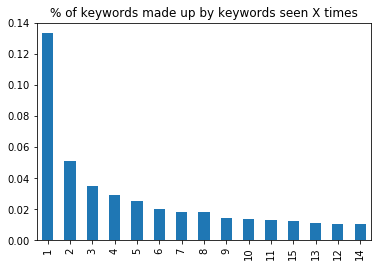

In [430]:
percent_series = (value_count_series / sum(value_count_series))
plt.cla()
percent_series[:15].sort_values(ascending=False).plot.bar(**{"title":"% of keywords made up by keywords seen X times"})
plt.show()

This is the integral of the previous plot.


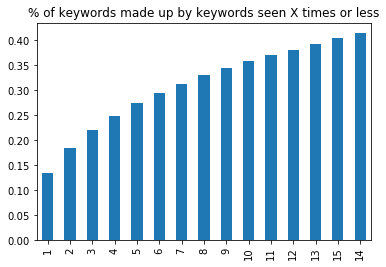

In [433]:
cumulative_series = percent_series.cumsum()
print("This is the integral of the previous plot.")
plt.cla()
cumulative_series[:15].plot.bar(**{"title": "% of keywords made up by keywords seen X times or less"})
plt.show()

# AI is somewhat popular

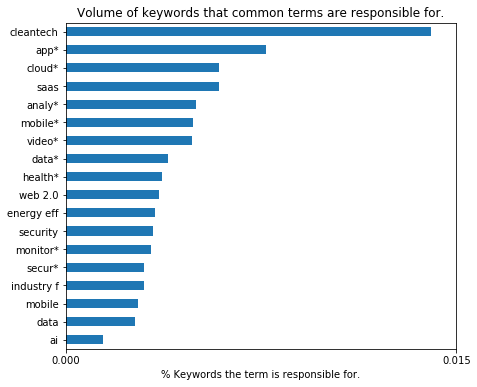


cleantech, the most popular keyword, only account for 1.5% of the keywords.


In [435]:
sorted_count_series = count_series.sort_values(ascending=False)
sorted_percent_series = sorted_count_series / sum(count_series)

sorted_percent_series.index = sorted_percent_series.index.map(lambda x: x[:10])
sorted_plus_ai = sorted_percent_series.copy()[:17].append(pd.DataFrame({0: 0.00145}, index=["ai"]))
plot_dict = {
    "title":"Volume of keywords that common terms are responsible for.",
    "figsize": (7, 6),
    "xticks": [0, .015],
    "legend": False
}
sorted_plus_ai[::-1].plot.barh(**plot_dict)

plt.xlabel("% Keywords the term is responsible for.")
plt.show()

print("\ncleantech, the most popular keyword, only account for 1.5% of the keywords.")

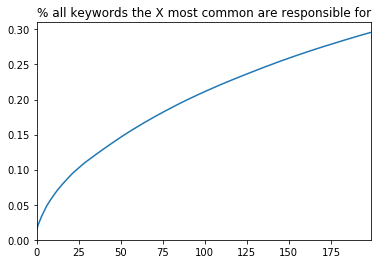

In [436]:
sorted_percent_series.cumsum()[:200].plot(use_index=False, **{"title":"% all keywords the X most common are responsible for"})
plt.show()

In [415]:
for ix, (keyword, percent) in enumerate(sorted_percent_series.iteritems()):
    if keyword == "ai":
        ai_ranking = ix + 1
        ai_percentage = percent
        break
ai_percentile = (len(keywords) - sorted_count_series.iloc[ix]) / float(len(keywords))
print("ai is the %dth most common keyword, in the %f percentile of keyword occurrence" % (ai_ranking, ai_percentile))
print("ai is %f as common as the most likely keyword" % (ai_percentage / sorted_percent_series.iloc[0]))

ai is the 62th most common keyword, in the 0.993052 percentile of keyword occurrence
ai is 0.103215 as common as the most likely keyword


In [416]:
print(count_series["ai"])

183


# AI-related keywords
Unfortunately, it seems like there is not a consistent methodology for determining keywords and there are difference derivations of the same keyword.

Example:

artificial intel\*, artificial intellig\*, artificial intelligen\*, artificial intelligenc\*, artificial intelligence\*, artificial intelligence

machine learn, machine learn\*, machine learning, machine learning\*, machine\* learn\*, machine\* learning\*

In [417]:
print("Unique Keywords: %d" % len(keywords))

Unique Keywords: 26340


I found all keywords that are substrings of AI-related words. Many of the terms did end up being useful, and are now in "words_not_used". See how this usefullness was determined in "Keyword Cleaning" section.

In [418]:
ai_words = ["ai", "agi", "artificial intelligence", "artificial intel*",
            "artificial intellig*", "artificial intelligen*", "artificial intelligenc*", "artificial intelligence*"]
ml_words = ["ml", "machine learn", "machine learn*", "machine learning",
            "machine learning*", "machine* learn*", "machine* learning*"]
cv_words = ["computer vision", "computer vision*", "computer* vision*"]

words_not_used = ([
    "neural networks", "deep learning", "reinforcement learning", # hot topics
    "statistics", "inference", "prediction", # statistical learning
    "convex", "optimization", "convex optimization", # optimization / control
    "probabilistic", "probabilistic programming", "graphical models" # bayesian
    "expert system",
    "data mining", "bi", "business intelligence"
])

# Entity IDs

In [419]:
words = ai_words + ml_words + cv_words

In [420]:
entity_ids = set()
for word in words:
    indices = keyword_to_ix[word]
    for ix in indices:
        entity_ids.add(df.loc[ix]["EntityID"])

In [421]:
entity_id_list = sorted(list(entity_ids))
len(entity_id_list)

321

In [424]:
with open(os.path.join(os.getcwd(), "AI_Entity_ID.csv"), "w") as f:
    f.write("EntityID\n")
    for e in entity_id_list:
        f.write("%d\n" % e)

# Keyword Cleaning

This section was used to identify keywords similar to:
"ai", "artificial intellgience", "machine learing", "computer vision".

I also used the code here to detemine that other AI-related keywords were too sparse / not useful.

In [350]:
words = ai_words + ml_words + cv_words

# Returns a set of keywords that are substrings of input keywords
def get_keyword_substrings(words):
    substrings = set()
    for w in words:
        for k in keywords:
            if k.replace("*", "") in w or w in k.replace("*", "") in w:
                substrings.add(k)
    return substrings

Many of the substrings were useless. I cleaned them up.

In [374]:
substrings = get_keyword_substrings(words)
useless_substrings = [
    "art*", "gen*", "art", "ar", "gi", "ag*", "ar*",
    "artificial*", "artificial",
    "intel*", "intellig*", "intellige*", "intelligen*",
    "intelligence*", "*intelligence", "intelligence", "intelli*",
    "mac", "mac*", "machin*", "ach", "machine", "machine*",
    "*learn*", "learn*", "learning", "learning*", "*learning", "*learning*", "learn",
    "comput*", "compute*", "computer*", "computer", "*comput*", "*comp*", "*computer*",
    "vision", "vision*", "vis*", "ion", "si", "io", "*vision*", "*vision",
    "chin*", "*", "ic", "ic*", "*ic*", "ear*", "ce",
    "ear", "earn*", "er", "ac", "uter*", "ion*", "mp",
    "tell*", "nce", "com", "ell", "*gen*", "ne",
    "ti", "ci*", "compute", "earning*", "ach*", "visi*", "gi*", "nce*", "co", "fi", "*machine*",
    "*art*", "*ic", "comp*", "*intelligen*", "*machin*", "*intelligence*", "*ag*", "nt", "intell*",
    "*intelli*", "is", "r"
]

for sub in useless_substrings:
    substrings.remove(sub)

substrings = list(substrings)

Display the # occurences of the remaining keywords in sorted order.

In [375]:
top_ten = count_series[set(words + substrings)].sort_values(ascending=False)
top_ten

ai                          183
machine learn*               59
artificial intelligence      59
machine learning             57
ai*                          26
computer vision              13
artificial intelligen*        8
computer vision*              6
machine learning*             4
artificial intelligence*      4
artificial intelligenc*       3
ml                            3
machine* learn*               2
machine* learning*            1
computer* vision*             1
machine learn                 1
artificial intellig*          1
artificial intel*             1
agi                           1
dtype: int64

Sanity check that the labelers are not accidentally writing one keyword as two ("artificial intellgience" as "artificial", "intelligence")

In [388]:
df[df["KeywordItems"].apply(lambda x: "artificial" in x and "intellgience" in x) == True]

,EntityID,Keywords,FullDesc,KeywordItems
